In [1]:
# import widen_notebook
from mysetup import NotebookFinder
import sys

sys.meta_path.append(NotebookFinder())

from setup_transform import *

%matplotlib inline
cl_weight = sklearn.utils.compute_class_weight(
    class_weight="balanced", classes=[0, 1, 2], y=y
)
CLASS_WEIGHTS = {i: cl_weight[i] for i in range(3)}
def_cv = RepeatedStratifiedKFold(n_splits=3, n_repeats=5, random_state=42)
lgr_params = dict(
    class_weight=CLASS_WEIGHTS,
    fit_intercept=False,
    multi_class="ovr",
    max_iter=2000000,
    random_state=42,
    n_jobs=24,
    penalty="elasticnet",
    cv=def_cv,
    scoring="f1_macro",
    solver="saga",
    Cs=100,
    l1_ratios=np.linspace(0, 1, endpoint=False, num=100),
)
from sklearnex import unpatch_sklearn

# unpatch_sklearn()
import copy
import warnings

warnings.filterwarnings("ignore")
discrete = nominal + discrete_ordinal + discrete_binary
X_master = pd.concat(
    [raw_data.loc[:, raw_data_eval.columns], raw_data_eval], ignore_index=True, axis=0
)

importing Jupyter notebook from setup_transform.ipynb


Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


In [29]:
X_master = pd.concat(
    [raw_data.loc[:, raw_data_eval.columns], raw_data_eval], ignore_index=True, axis=0
)
raw_data

,nominal__v_21,nominal__v_32,ordinal__v_15,nominal__v_4,binary__v_1,ratio__v_8,nominal__v_12,nominal__v_25,nominal__v_20,nominal__v_18,nominal__v_3,binary__v_11,binary__v_14,binary__v_26,binary__v_27,binary__v_30,binary__v_9,ordinal__v_31,binary__v_28,ordinal__v_13,ordinal__v_33,ordinal__v_17,ordinal__v_19,ordinal__v_29,ordinal__v_23,ordinal__v_24,ordinal__v_10,ordinal__v_5,ordinal__v_6,ordinal__v_22,ordinal__v_0,ratio__v_7,ratio__v_2,ratio__v_16,ratio__v_34,ratio__v_35,ratio__v_36,ratio__v_37,ratio__v_38,ratio__v_39,ratio__v_40,target,binary__sum,binary__literal,ordinal__norm
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,0,0,1,15,1,0.008441,0,4,14,23,9,1,0,0,1,0,0,1,0,0,6,7,6,16,0,0,6,6,6,15,0,0.117330,-0.002532,0.006668,0.008441,0.785015,0.396728,0.008441,0.405169,0.219467,0.000000,1,0.375,0.784314,-0.018842
1,5,25,2,24,1,0.046934,6,3,35,49,37,0,1,1,0,1,1,2,0,9,7,14,9,12,1,4,7,15,5,14,1,0.174828,0.063361,0.076385,0.070401,0.340270,0.434137,0.293336,0.621873,0.410671,0.082134,2,0.625,0.701961,0.560898
2,0,62,0,63,1,0.014645,0,0,26,23,16,1,0,0,1,1,0,6,0,0,6,7,6,13,0,0,6,6,4,12,0,0.162557,0.008787,0.029583,0.014645,0.117158,0.497923,0.058579,0.629727,0.556503,0.029290,1,0.500,0.792157,-0.189751
3,0,0,3,46,1,0.010025,0,0,0,16,39,1,0,0,1,0,1,1,0,0,7,7,7,13,0,0,8,9,7,12,0,0.111280,0.006015,0.020251,0.070177,0.370935,0.401011,0.270682,0.431087,0.651643,0.000000,1,0.500,0.788235,-0.034360
4,1,24,8,4,1,0.278320,6,28,30,44,28,0,0,1,0,1,1,24,0,5,18,20,23,23,4,13,13,19,19,17,2,0.178452,0.137523,0.204811,0.261948,0.360178,0.409294,0.409294,0.392922,0.376550,0.016372,1,0.500,0.576471,3.319132
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3791,0,20,3,36,1,0.010002,0,0,0,16,9,1,0,0,1,1,0,2,0,0,6,7,5,12,0,0,6,12,2,12,0,0.076013,0.026004,0.003201,0.070012,0.770130,0.420071,0.380064,0.120020,0.240041,0.050008,2,0.500,0.792157,-0.179272
3792,4,2,10,55,1,0.007522,9,5,4,22,28,0,1,1,1,1,1,5,0,8,11,14,9,18,0,0,16,13,16,17,3,0.093274,0.063938,0.028509,0.097788,0.564159,0.135398,0.263274,0.473894,0.586725,0.045133,2,0.750,0.733333,1.596397
3793,2,64,4,18,1,0.140715,7,0,36,21,26,0,1,1,1,1,1,5,0,3,9,16,7,19,5,9,14,18,3,19,8,0.092872,0.013133,0.032927,0.112572,0.525335,0.121953,0.318953,0.112572,0.741097,0.056286,0,0.750,0.733333,1.565504


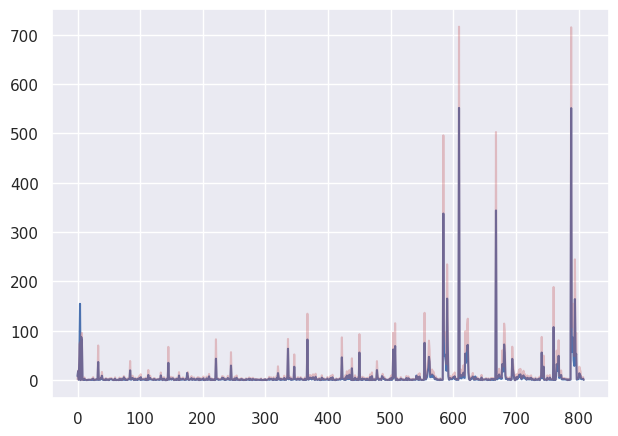

In [ ]:
X_o = pd.get_dummies(raw_data.loc[:, discrete], columns=nominal + discrete_ordinal)
y = raw_data.target

_ = plt.plot(f_classif(X_o, raw_data.target)[0])
_ = plt.plot(chi2(X_o, raw_data.target)[0], color="r", alpha=0.3)

In [ ]:
X_o_eval = pd.get_dummies(
    raw_data_eval.loc[:, discrete], columns=nominal + discrete_ordinal
)
X_o_eval

,binary__v_1,binary__v_11,binary__v_14,binary__v_26,binary__v_27,binary__v_28,binary__v_30,binary__v_9,nominal__v_12_0,nominal__v_12_1,nominal__v_12_2,nominal__v_12_3,nominal__v_12_4,nominal__v_12_5,nominal__v_12_6,nominal__v_12_7,nominal__v_12_8,nominal__v_12_9,nominal__v_12_10,nominal__v_12_11,nominal__v_12_12,nominal__v_12_13,nominal__v_12_14,nominal__v_12_15,nominal__v_12_16,...,ordinal__v_5_24,ordinal__v_5_25,ordinal__v_5_26,ordinal__v_5_27,ordinal__v_6_0,ordinal__v_6_1,ordinal__v_6_2,ordinal__v_6_3,ordinal__v_6_4,ordinal__v_6_5,ordinal__v_6_6,ordinal__v_6_7,ordinal__v_6_8,ordinal__v_6_9,ordinal__v_6_10,ordinal__v_6_11,ordinal__v_6_12,ordinal__v_6_13,ordinal__v_6_14,ordinal__v_6_15,ordinal__v_6_16,ordinal__v_6_17,ordinal__v_6_18,ordinal__v_6_19,ordinal__v_6_20
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,1,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
1,1,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
2,1,1,0,0,1,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,1,1,0,0,1,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,1,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1623,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1624,1,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
1625,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [68]:
"""
Min Samples with all Categories
"""
vc_discrete = {c: X_master[c].value_counts() for c in nominal + discrete_ordinal}
freq_cols = [c + "_freq" for c in nominal + discrete_ordinal]
X_raw = raw_data.copy()
X_eval = raw_data_eval.copy()
X_raw.loc[:, freq_cols] = 0
X_eval.loc[:, freq_cols] = 0


def input_freq(row):
    for c in nominal + discrete_ordinal:
        row[c + "_freq"] = vc_discrete[c][row[c]]
    return row


X_raw = X_raw.apply(input_freq, axis=1)
X_eval = X_eval.apply(input_freq, axis=1)
X_raw[nominal + discrete_ordinal + freq_cols + discrete_binary] = X_raw[
    nominal + discrete_ordinal + freq_cols + discrete_binary
].astype(np.uint16)
X_eval[nominal + discrete_ordinal + discrete_binary + freq_cols] = X_eval[
    nominal + discrete_ordinal + freq_cols + discrete_binary
].astype(np.uint16)
X_master[freq_cols] = pd.concat(
    [X_raw.loc[:, freq_cols], X_eval.loc[:, freq_cols]], ignore_index=True, axis=0
)
enc = OrdinalEncoder()
enc.fit(X_master[freq_cols])
X_raw[freq_cols] = enc.transform(X_raw[freq_cols]).astype(np.uint16)
X_eval[freq_cols] = enc.transform(X_eval[freq_cols]).astype(np.uint16)

X, y = (
    X_raw.loc[:, nominal + discrete_ordinal + discrete_binary + freq_cols],
    raw_data.target,
)
cat_idx = {c: {} for c in nominal + discrete_ordinal}
for c in nominal + discrete_ordinal:
    categories = X[c].unique()
    for ca in categories:
        cat_idx[c][ca] = X[X[c] == ca].index
    # for c_ in discrete_ordinal:
from numpy.random import default_rng


def gen_rand_unique_idx(cat_idx):
    dfe1 = default_rng()
    m_idx = set()
    for c in cat_idx:
        for k, v in cat_idx[c].items():
            dfe = default_rng(seed=dfe1.integers(0, dfe1.integers(0, 2121231212)))
            _ = dfe.choice(v, replace=False)
            # for e_ in _:
            m_idx.add(_)
    return m_idx


fin_idx = gen_rand_unique_idx(cat_idx)
for _ in range(500):
    tmp = gen_rand_unique_idx(cat_idx)
    fin_idx = fin_idx.intersection(tmp)

nw_X = X.loc[fin_idx, :]
for c in nominal + discrete_ordinal:
    tot = X[c].unique()
    av = nw_X[c].unique()
    miss = np.setdiff1d(tot, av)
    for m in miss:
        unc = np.setdiff1d(cat_idx[c][m], fin_idx)
        dfe = default_rng()
        ani = dfe.choice(unc)
        fin_idx.add(ani)
fin_idx = np.array(list(fin_idx))

In [159]:
ALPHA = 1.0e-10
clf_1 = CategoricalNB(alpha=ALPHA, fit_prior=True, min_categories=2)
clf_2 = ComplementNB(alpha=ALPHA, fit_prior=True, norm=False)
clf_3 = BernoulliNB(binarize=False, alpha=ALPHA, fit_prior=True)
clf_4 = MultinomialNB(alpha=ALPHA, fit_prior=True)
# clf1_ = make_pipeline(VarianceThreshold(0.0001),clf_1)
# clf2_ = make_pipeline(VarianceThreshold(0.0001),clf_2)
# clf3_  = make_pipeline(VarianceThreshold(0.0001),clf_3)
# clf4_  = make_pipeline(VarianceThreshold(0.0001),clf_4)

clfs = []
for clf in [clf_1, clf_2, clf_3, clf_4]:
    clfs.append(OneVsOneClassifier(clf, n_jobs=-1))
# clfs = [clf1_,clf2_,clf3_,clf4_]

ct = make_column_transformer(
    (OneHotEncoder(sparse=False), nominal + discrete_ordinal + freq_cols),
    ("passthrough", discrete_binary),
    sparse_threshold=0,
    n_jobs=-1,
)
ct.fit(X_raw)

X, y = (
    pd.DataFrame(ct.transform(X_raw), columns=cleanup_feature_names(ct)),
    raw_data.target,
)

other = X_raw.index.difference(fin_idx)

X_train, X_test, y_train, y_test = gen_train_test(
    X.loc[other, :], y.loc[other], test_size=0.3
)
# X.

In [160]:
res = []
with parallel_backend("loky"):
    for clf in clfs:
        #     sc = cross_validate(clf,X,y,cv=RepeatedStratifiedKFold(),n_jobs=-1,scoring='f1_macro',)
        #     res.append(sc)
        #     clf = clf_[-1]
        clf.partial_fit(X.loc[fin_idx, :], y.loc[fin_idx], classes=[0, 1, 2])
        #     clf.partial_fit(X[fin_idx,:],y.loc[fin_idx],classes=[0,1,2])
        cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=20)

        for train_index, test_index in cv.split(X_train, y_train):
            X_train_, X_test_ = X.loc[train_index, :], X.loc[test_index, :]
            y_train_, y_test_ = y.loc[train_index], y.loc[test_index]
            #         clf.partial_fit(X_test_,y_test_)
            clf.partial_fit(X_test_, y_test_, classes=[0, 1, 2])
            #         print(X_train.shape)

            clf.partial_fit(X_train_, y_train_, classes=[0, 1, 2])
    #         clf.partial_fit(X_train_,y_train_)

              precision    recall  f1-score   support

           0       0.73      0.65      0.69       338
           1       0.81      0.74      0.77       511
           2       0.43      0.61      0.51       192

    accuracy                           0.69      1041
   macro avg       0.66      0.67      0.66      1041
weighted avg       0.71      0.69      0.70      1041

              precision    recall  f1-score   support

           0       0.74      0.63      0.68       338
           1       0.82      0.74      0.78       511
           2       0.42      0.65      0.51       192

    accuracy                           0.69      1041
   macro avg       0.66      0.67      0.66      1041
weighted avg       0.72      0.69      0.70      1041

              precision    recall  f1-score   support

           0       0.73      0.65      0.69       338
           1       0.81      0.74      0.77       511
           2       0.43      0.61      0.51       192

    accuracy        

[]

In [162]:
y_preds = [clf.predict(X_test) for clf in clfs]
y_pred_base = clf.fit(X_train, y_train).predict(X_test)


print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.73      0.63      0.68       338
           1       0.80      0.76      0.78       511
           2       0.44      0.60      0.51       192

    accuracy                           0.69      1041
   macro avg       0.66      0.66      0.65      1041
weighted avg       0.71      0.69      0.70      1041



In [39]:
f_names = cleanup_feature_names(ct)
f_lp = {
    x: {j: clfs[0].feature_log_prob_[i][j][1] for j in range(3)}
    for i, x in enumerate(f_names)
}
# cnb.classes_
import pprint

# pprint.pprint(f_lp)
categorical_importances = pd.DataFrame(f_lp).transpose()
for i in range(2, 4):
    for j in range(3):
        categorical_importances[f"nb_{i}_{j}"] = clfs[i].feature_log_prob_[j]

In [40]:
categorical_importances.transform(np.exp)

,0,1,2,nb_2_0,nb_2_1,nb_2_2,nb_3_0,nb_3_1,nb_3_2
nominal__v_12_0,0.814336,0.824226,0.791678,0.814336,0.824226,0.791678,0.032220,0.032321,0.031101
nominal__v_12_1,0.018799,0.019060,0.020026,0.018799,0.019060,0.020026,0.000744,0.000747,0.000787
nominal__v_12_2,0.016596,0.018320,0.024037,0.016596,0.018320,0.024037,0.000657,0.000718,0.000944
nominal__v_12_3,0.027626,0.015379,0.020026,0.027626,0.015379,0.020026,0.001093,0.000603,0.000787
nominal__v_12_4,0.016596,0.013913,0.028021,0.016596,0.013913,0.028021,0.000657,0.000546,0.001101
...,...,...,...,...,...,...,...,...,...
binary__v_26,0.350958,0.195487,0.266322,0.350958,0.195487,0.266322,0.013886,0.007666,0.010463
binary__v_27,0.558718,0.829344,0.789812,0.558718,0.829344,0.789812,0.022106,0.032522,0.031028
binary__v_28,0.037569,0.041003,0.034096,0.037569,0.041003,0.034096,0.001486,0.001608,0.001339
binary__v_30,0.581255,0.356987,0.486183,0.581255,0.356987,0.486183,0.022998,0.013999,0.019100


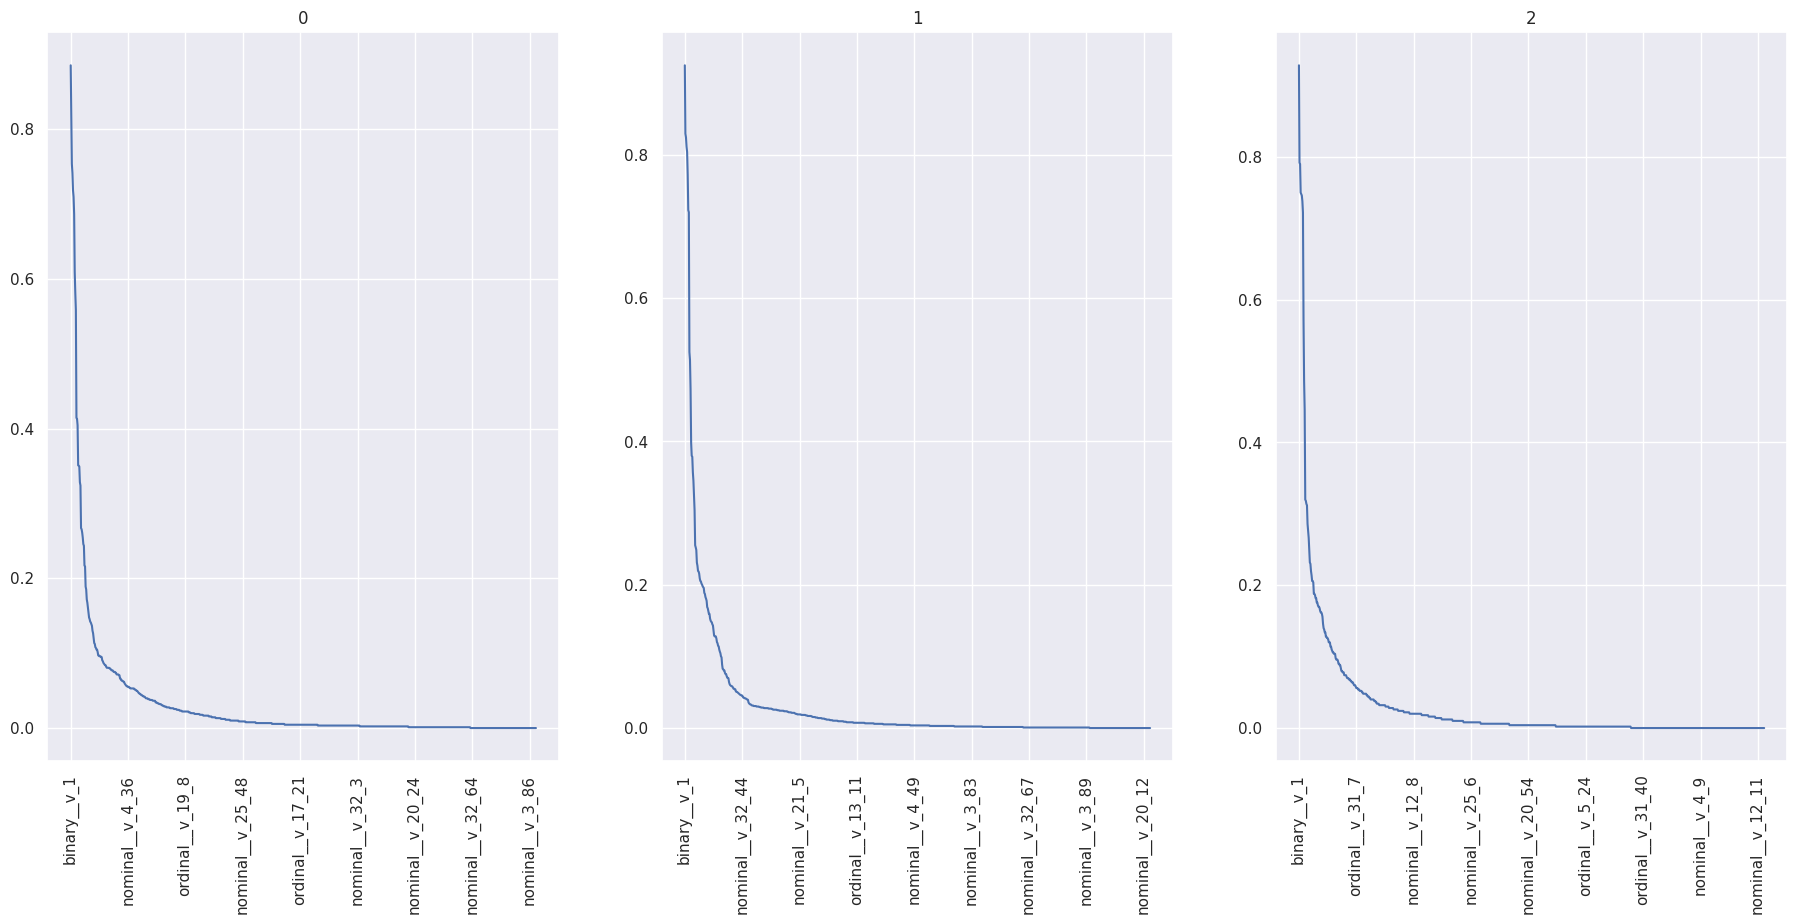

In [ ]:
fig, ax = plt.subplots(1, 3, figsize=(20, 9))
_ = (
    categorical_importances[0]
    .transform(np.exp)
    .sort_values(ascending=False)
    .plot(rot=90, ax=ax[0], title="0")
)
_ = (
    categorical_importances[1]
    .transform(np.exp)
    .sort_values(ascending=False)
    .plot(rot=90, ax=ax[1], title="1")
)
_ = (
    categorical_importances[2]
    .transform(np.exp)
    .sort_values(ascending=False)
    .plot(rot=90, ax=ax[2], title="2")
)

In [ ]:
best_categories = {}
nominal_only = [x for x in categorical_importances.index if "nominal__" in x]
for i in range(3):
    imp_col_i = (
        categorical_importances.loc[nominal_only, i].sort_values(ascending=False).index
    )
    best_categories[i] = imp_col_i[:40]

In [ ]:
categorical_importances.loc[best_categories[1], :]

,0,1,2
nominal__v_12_0,-0.205382,-0.193310,-0.233601
nominal__v_21_0,-0.376115,-0.258294,-0.293348
nominal__v_32_0,-1.532613,-0.920886,-1.139836
nominal__v_18_41,-1.326022,-1.121288,-1.386881
nominal__v_3_55,-1.686906,-1.517782,-1.784326
nominal__v_20_50,-1.368391,-1.521098,-1.580378
nominal__v_25_0,-1.760870,-1.583239,-1.542036
nominal__v_20_30,-1.912830,-1.586684,-1.590198
nominal__v_4_46,-2.605978,-1.608557,-2.087629
nominal__v_25_20,-1.927963,-1.626921,-1.760334


In [43]:
clfs[3].feature_log_prob_.shape

(3, 812)

In [24]:
from kmodes.kprototypes import KPrototypes

kproto = KPrototypes(verbose=1, random_state=42, n_jobs=-1)
kproto.fit(
    raw_data.loc[:, nominal + discrete_ordinal + discrete_binary + ratios],
    raw_data.target,
    categorical=list(range(30)),
)

# = clfs[1].feature_log_prob_[1]
# clfs[2].feature_log_prob_[1].

Initialization method and algorithm are deterministic. Setting n_init to 1.
Best run was number 9


KPrototypes(gamma=0.056986620700930975, n_jobs=-1, random_state=42, verbose=1)

In [62]:
raw_data[c]

,nominal__v_21,nominal__v_32,ordinal__v_15,nominal__v_4,binary__v_1,ratio__v_8,nominal__v_12,nominal__v_25,nominal__v_20,nominal__v_18,nominal__v_3,binary__v_11,binary__v_14,binary__v_26,binary__v_27,binary__v_30,binary__v_9,ordinal__v_31,binary__v_28,ordinal__v_13,ordinal__v_33,ordinal__v_17,ordinal__v_19,ordinal__v_29,ordinal__v_23,...,binary__sum,binary__literal,ordinal__norm,nominal__v_12_freq,nominal__v_18_freq,nominal__v_20_freq,nominal__v_21_freq,nominal__v_25_freq,nominal__v_3_freq,nominal__v_32_freq,nominal__v_4_freq,ordinal__v_0_freq,ordinal__v_10_freq,ordinal__v_13_freq,ordinal__v_15_freq,ordinal__v_17_freq,ordinal__v_19_freq,ordinal__v_22_freq,ordinal__v_23_freq,ordinal__v_24_freq,ordinal__v_29_freq,ordinal__v_31_freq,ordinal__v_33_freq,ordinal__v_5_freq,ordinal__v_6_freq
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,0,0,1,15,1,0.008441,0,4,14,23,9,1,0,0,1,0,0,1,0,0,6,7,6,16,0,...,0.375,0.784314,-0.018842,21,43,41,24,47,38,55,45,28,40,50,26,47,38,20,15,18,15,36,22,26,21
1,5,25,2,24,1,0.046934,6,3,35,49,37,0,1,1,0,1,1,2,0,9,7,14,9,12,1,...,0.625,0.701961,0.560898,14,27,16,13,22,17,25,5,26,32,33,25,30,20,22,14,15,22,35,20,16,19
2,0,62,0,63,1,0.014645,0,0,26,23,16,1,0,0,1,1,0,6,0,0,6,7,6,13,0,...,0.500,0.792157,-0.189751,21,43,29,24,54,43,36,44,28,40,50,30,47,38,26,15,18,21,27,22,26,18
3,0,0,3,46,1,0.010025,0,0,0,16,39,1,0,0,1,0,1,1,0,0,7,7,7,13,0,...,0.500,0.788235,-0.034360,21,45,43,24,54,48,55,48,28,35,50,23,47,32,26,15,18,21,36,20,24,16
4,1,24,8,4,1,0.278320,6,28,30,44,28,0,0,1,0,1,1,24,0,5,18,20,23,23,4,...,0.500,0.576471,3.319132,14,22,44,21,14,46,18,4,21,26,36,12,18,1,17,11,5,4,15,9,12,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3791,0,20,3,36,1,0.010002,0,0,0,16,9,1,0,0,1,1,0,2,0,0,6,7,5,12,0,...,0.500,0.792157,-0.179272,21,45,43,24,54,38,53,41,28,40,50,23,47,34,26,15,18,22,35,22,20,14
3792,4,2,10,55,1,0.007522,9,5,4,22,28,0,1,1,1,1,1,5,0,8,11,14,9,18,0,...,0.750,0.733333,1.596397,10,17,26,15,30,46,32,16,19,13,32,9,30,20,17,15,18,14,32,15,18,6
3793,2,64,4,18,1,0.140715,7,0,36,21,26,0,1,1,1,1,1,5,0,3,9,16,7,19,5,...,0.750,0.733333,1.565504,10,18,24,12,54,7,1,34,11,23,37,22,25,32,18,9,11,11,32,14,13,15


In [4]:
compactor = defaultdict(list)


def compact_nominal(threshold):
    global compactor
    X = raw_data.copy()
    tmp = X[X["target"] == 1]
    for c in nominal:
        vc = tmp[c].value_counts().sort_values(ascending=False)
        cum_vc = vc.cumsum(axis=0)
        consolid = cum_vc[cum_vc > threshold * tmp.shape[0]].index
        compactor[c] = list(consolid)


def compact_ordinal(threshold):
    global compactor
    X = raw_data.copy()
    tmp = X[X["target"] == 1]
    for c in discrete_ordinal:
        vc = tmp[c].value_counts().sort_values(ascending=False)
        cum_vc = vc.cumsum(axis=0)
        consolid = cum_vc[cum_vc > threshold * tmp.shape[0]].index
        compactor[c] = list(consolid)


def compact_discrete(row):
    for c in compactor:
        if row[c] in compactor[c]:
            row[c] = int(np.median(compactor[c]))
    return row


X = raw_data.copy()

X = X.apply(compact_discrete, axis=1)
X_dum = pd.get_dummies(X[raw_data_eval.columns], columns=nominal)
raw_dum = pd.get_dummies(
    raw_data[raw_data_eval.columns], columns=nominal + discrete_ordinal
)
# ct = make_column_transformer()
clf1 = OneVsOneClassifier(MultinomialNB(alpha=1e-10))
# clf2 = OneVsOneClassifier(BernoulliNB(alpha=1e-10))
clf3 = OneVsOneClassifier(ComplementNB(alpha=1e-10))
estimators = [
    ("1", clf1),
    #     ('2',clf2),
    ("3", clf3),
]
clf = StackingClassifier(estimators=estimators, n_jobs=-1)
scores = cross_validate(
    clf,
    X_dum.abs(),
    y,
    scoring="f1_macro",
    cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
    return_train_score=True,
)
scores2 = cross_validate(
    clf,
    raw_dum.abs(),
    y,
    scoring="f1_macro",
    cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
    return_train_score=True,
)
print("New", scores["test_score"].mean(), scores["train_score"].mean())
print("Old", scores2["test_score"].mean(), scores2["train_score"].mean())

New 0.5589368474028269 0.6077812013471977
Old 0.5071632941886255 0.5488706999235653


In [28]:
discrete = nominal
X = raw_data.copy()
X = X[(X["target"] != 2) & (X["target"] != 0)]
X.shape

(1863, 45)

0.4476802561627386 0.5154529084801222
0.44864948592166776 0.5547444510609237


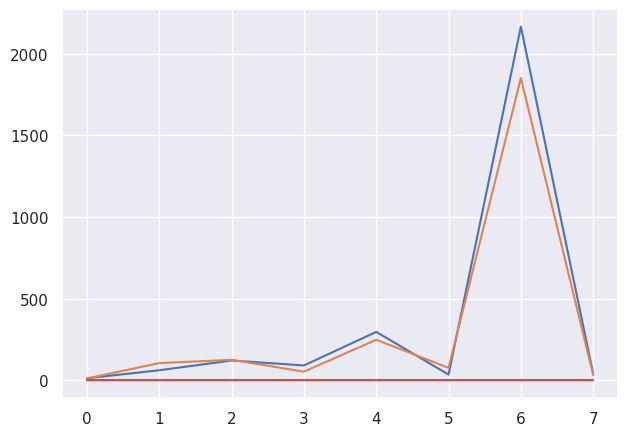

In [26]:
y = raw_data.target
chi_old = chi2(raw_data[nominal], y)
chi_new = chi2(X[nominal], y)
plt.plot(chi_old[0])
_ = plt.plot(chi_new[0])
plt.plot(chi_old[1])
_ = plt.plot(chi_new[1])

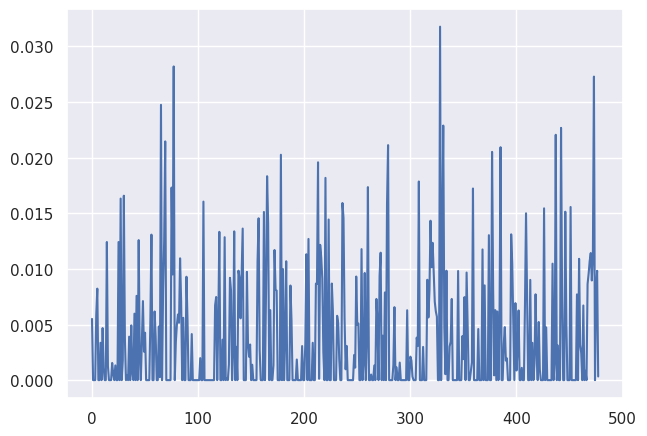

In [18]:
_ = plt.plot(mic_old)

array([[0, 1, 0],
       [0, 0, 1],
       [0, 1, 0],
       ...,
       [1, 0, 0],
       [0, 1, 0],
       [1, 0, 0]])

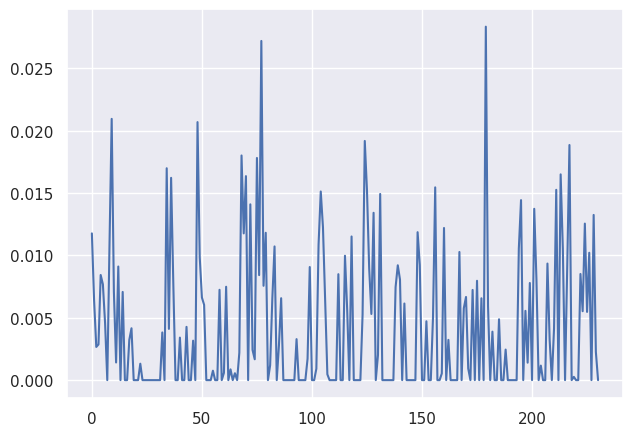

In [19]:
_ = plt.plot(mic_new)

In [176]:
fs = [
    "ordinal__v_0",
    "ordinal__v_23",
    "ordinal__v_24",
    "ordinal__v_13",
    "ordinal__v_15",
    "binary__v_1",
    "binary__v_28",
    "nominal__v_12",
    "nominal__v_21",
]
fs = nominal + discrete_ordinal + ["binary__sum"]
fs = freq_cols
import itertools

d = (
    list(itertools.combinations(fs, 3))
    + list(itertools.combinations(fs, 4))
    + list(itertools.combinations(fs, 5))
    + list(itertools.combinations(fs, 2))
)
d = list(itertools.combinations(fs, 5))

In [177]:
from tqdm import tqdm, trange

diff_order_pairs = defaultdict(list)
for order in tqdm(d):
    ewq = (
        X_raw.groupby(list(order), squeeze=True)["target"]
        .value_counts()
        .unstack()
        .fillna(0)
        .astype(np.uint16)
    )
    diff_order_pairs[ewq.shape[0]].append(order)

100%|██████████| 26334/26334 [01:22<00:00, 318.48it/s]


850

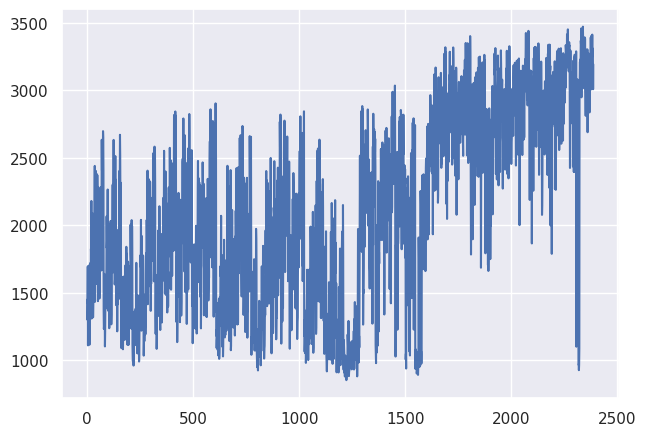

In [178]:
plt.plot(diff_order_pairs.keys())
min_ck = min(diff_order_pairs)
min(diff_order_pairs)